# More Parallelising emcee using IPython parallel

In a [previous post](./2015-06-26-Parallelising-emcee-using-IPython-parallel.html) I demonstrated how IPython parallel could be used to speed up MCMC simulations using `emcee`. However this was limited as we collected the `chain` attributes on each of the remote view and gathered them together returning just this from any simulation. This drops a lot of the functionality that comes from using the `emcee` `sampler` object itself. In particular I have some code that takes such an object and calls the Thermodynamic integaration method. I'd really like to leave this code alone, but also use IPython parallel. 

## Warning

These methods do not order the samples other than removing the burnin period. So if after the burn-in the samples have not converged then this will produce some odd looking results!


### Setup a sampler

In [1]:
%matplotlib inline

from __future__ import print_function

import emcee
import triangle
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# Reproducible results!
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))

# Set up the sampler.
ntemps, ndim, nwalkers = 5, 3, 100
pos = [[result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] 
        for j in range(ntemps)]
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, lnlike, lnprior, loglargs=(x, y, yerr))

In [2]:
sampler.paralell = True

It is this sampler which has all the methods and functionality that we want. For example let's run it and see the size of the out output chains:

### Without IPython parrallel

In [3]:
N = 200
sampler.reset()
out = sampler.run_mcmc(pos, N)

In [4]:
sampler.chain.shape

(5, 100, 200, 3)

In [5]:
sampler.thermodynamic_integration_log_evidence()

(-23.191335531307175, 13.004314956762492)

### Create a new sampler object

Since we do not need *all* of the functionality of the sampler object, we just want to mimic parts of it. We now create a new sampler class with the attributes. Note that we take the `thermodynamic_integration_log_evidence` directly from the `PTSampler`. I am sure there is a better way to do this by subclassing the `PTSample`, but I can't see how to do it!

In [6]:
class sampler_data():
    def __init__(self, chain, lnlikelihood, betas):
        self.chain = chain
        self.lnlikelihood = lnlikelihood
        self.betas = betas
        
sampler_data.thermodynamic_integration_log_evidence = emcee.PTSampler.thermodynamic_integration_log_evidence.im_func

This limits to only the functionality that we have provided here.

### The general idea


Here I create an instance of the `sampler_data` object from out original sampler. Just passing in the requirements for the `thermodynamic_integration_log_evidence` method to run

In [7]:
sampler2 = sampler_data(sampler.chain, sampler.lnlikelihood, sampler.betas)

Then we can call the method and get the answer:

In [8]:
sampler2.thermodynamic_integration_log_evidence()

(-23.191335531307175, 13.004314956762492)

The use of this is that once we have run our MCMC simulations in parallel, we gather together all the attributes such as the `chain`s and `betas`, then pass them into a single new object. This object is passed onto the post-processing scripts which don't worry whether it was created using a single machine or several!

### Example

First import the `paralllel` module and set up a `dview`

In [9]:
import os,sys,time
import numpy as np

from IPython import parallel
rc = parallel.Client()
dview = rc[:]
dview.block = True
dview.use_dill()  # Standard pickle fails with functions

dview.execute("import numpy as np")

print(len(dview))

4


Now create a run function to wrap up the process. This splits the nwalkers over the nviews, then adds them back together so that in the end, we get the same number of walkers etc as we would *without* using parallelisation:

In [10]:
def run(dview, sampler, **kwargs):
    """ Run the sampler on all instances of the dview

    This spreads the total workload over the n views. The basic idea is to
    reduce the number of walkers on each view in inverse proportion to the
    number of view that we have. So, it will reduce the time for any simultion
    by a factor 1/nviews while still producing equivalent results.

    """

    nviews = len(dview)

    for key, val in kwargs.items():
        dview[key] = val

    def MakeEven(j):
        if j % 2 == 0:
            return j
        else:
            return j+1

    nwalkers_list = [MakeEven(int(sampler.nwalkers/nviews))
                     for j in range(len(dview)-1)]
    nwalkers_list.append(MakeEven(sampler.nwalkers - sum(nwalkers_list)))
    print("Setting up walkers on each machine:\n"
          "Machine: Walkers")
    for i, nwalkers in enumerate(nwalkers_list):
        print("{} : {}".format(i, nwalkers))
        dview.push(dict(nwalkers=nwalkers, ID=i), targets=i)
    print("Total: {}".format(sum(nwalkers_list)))

    dview['sampler'] = sampler

    dview.execute(
        "sampler.nwalkers = nwalkers\n"
        "sampler.reset()\n"
        "pos = np.array(pos)[:, ID*nwalkers:(ID+1)*nwalkers, :]\n"
        "sampler.run_mcmc(pos, nsteps)\n"
        "chain = sampler.chain[:, :, :, :]\n"
        "lnlikelihood = sampler.lnlikelihood[:, :, :]\n")

    chain = np.concatenate(dview.get("chain"), axis=1)
    lnlikelihood = np.concatenate(dview.get("lnlikelihood"), axis=1)

    return sampler_data(chain, lnlikelihood, sampler.betas)

and now we run it

In [12]:
nsteps=200
sampler3 = emcee.PTSampler(ntemps, nwalkers, ndim, lnlike, lnprior, loglargs=(x, y, yerr))
samplerD = run(dview, sampler3, pos=pos, nsteps=nsteps)

Setting up walkers on each machine:
Machine: Walkers
0 : 26
1 : 26
2 : 26
3 : 22
Total: 100


We want to check that the sampler attributes are the same as those run without the parallelisation:

In [13]:
print(samplerD.chain.shape, samplerD.lnlikelihood.shape, samplerD.betas.shape)

(5, 100, 200, 3) (5, 100, 200) (5,)


In [14]:
print(sampler.chain.shape, sampler.lnlikelihood.shape, sampler.betas.shape)

(5, 100, 200, 3) (5, 100, 200) (5,)


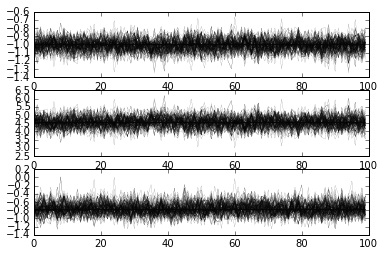

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)
ax1.plot(samplerD.chain[0, :, :, 0], lw=0.1, color="k")
ax2.plot(samplerD.chain[0, :, :, 1], lw=0.1, color="k")
ax3.plot(samplerD.chain[0, :, :, 2], lw=0.1, color="k")
plt.show()

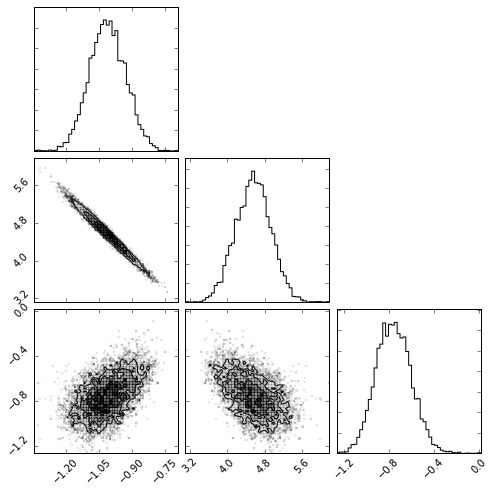

In [21]:
triangle.corner(samplerD.chain[0, :, 100:, :].reshape((-1, ndim)))
plt.show()

In [17]:
samplerD.thermodynamic_integration_log_evidence()

(-23.15222661351962, 12.92817429141564)

## Timing the methods

In [18]:
npoints = 1000
burnin = 100
sampler.reset()
%timeit out = sampler.run_mcmc(pos, npoints, rstate0=np.random.get_state())

1 loops, best of 3: 14.4 s per loop


In [20]:
npoints = 1000
burnin = 100
sampler3.reset()

%timeit samplerD = run(dview, sampler3, pos=pos, npoints=npoints, burnin=burnin, ndim=ndim, ntemps=ntemps, lnprior=lnprior, lnlike=lnlike)

Setting up walkers on each machine:
Machine: Walkers
0 : 26
1 : 26
2 : 26
3 : 22
Total: 100
Setting up walkers on each machine:
Machine: Walkers
0 : 26
1 : 26
2 : 26
3 : 22
Total: 100
Setting up walkers on each machine:
Machine: Walkers
0 : 26
1 : 26
2 : 26
3 : 22
Total: 100
Setting up walkers on each machine:
Machine: Walkers
0 : 26
1 : 26
2 : 26
3 : 22
Total: 100
1 loops, best of 3: 1.1 s per loop


These results were conducted with 6 cores, so this makes sense, we cut the total running time by 6 with 8 secs additional overhead setting the problem up